In [1]:
import os
import cv2
import torch
from nanodet.util import cfg, load_config, Logger

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

device = torch.device('cuda')

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [11]:
from nanodet.model.arch import build_model
from nanodet.util import Logger, cfg, load_config, load_model_weight
from nanodet.data.transform import Pipeline
from nanodet.data.collate import naive_collate
from nanodet.data.batch_process import stack_batch_img
import numpy as np

class WrapperModel(torch.nn.Module):
    def __init__(self, cfg, model_path, logger, device="cuda:0"):
        super().__init__()

        self.cfg = cfg
        self.device = device
        
        self.num_classes = cfg['model']['arch']['head']['num_classes']
        self.reg_max = cfg['model']['arch']['head']['reg_max']
        model = build_model(cfg.model)
        ckpt = torch.load(model_path, map_location=lambda storage, loc: storage)
        load_model_weight(model, ckpt, logger)
        self.model = model.to(device).eval()

    def forward(self, tensor_img):
        if len(tensor_img.shape) == 4:

            preds = self.model(tensor_img)
            cls_scores, boxes = preds.split(
                [self.num_classes, 4 * (self.reg_max + 1)], dim=-1
            )
            
            print(boxes)
            
            max_cls_scores = torch.max(cls_scores.sigmoid(), dim=1)[0]
            return max_cls_scores

In [13]:
config_path = 'assets/nanodet-300/nanodet-300.pth_train_config.yml'
model_path = 'assets/nanodet-300/nanodet-300.pth'
image_path = 'dataset/night/20201201_000505.jpg'

load_config(cfg, config_path)
logger = Logger(-1, use_tensorboard=False)
wrapper = WrapperModel(cfg, model_path, logger, device=device)

img = cv2.imread(image_path)

raw_height = img.shape[0]
raw_width  = img.shape[1]
dst_width, dst_height = cfg.data.val.input_size
ResizeM = np.eye(3)
ResizeM[0, 0] *= dst_width / raw_width
ResizeM[1, 1] *= dst_height / raw_height

# scaling only
numpy_img_warped = cv2.warpPerspective(img, 
                                       ResizeM, 
                                       dsize=tuple(cfg.data.val.input_size), 
                                       flags = cv2.INTER_LINEAR, 
                                       borderMode = cv2.BORDER_CONSTANT)

# normalise
mean, std = cfg.data.val.pipeline["normalize"]
mean = np.array(mean, dtype=np.float32).reshape(1, 1, 3) / 255
std = np.array(std, dtype=np.float32).reshape(1, 1, 3) / 255
numpy_img_normalised = ((numpy_img_warped.astype(np.float32) / 255) - mean) / std

# numpy to pytorch
processed_tensor_img = torch.from_numpy(numpy_img_normalised.transpose(2, 0, 1)).to(device).type(torch.cuda.FloatTensor).unsqueeze(0)

# input_   = torch.cat([processed_tensor_img, processed_tensor_img])
input_ = processed_tensor_img
print(input_.shape)
print(wrapper(input_))

model size is  1.0x
init weights...
=> loading pretrained model https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth
Finish initialize NanoDet Head.
torch.Size([1, 3, 320, 320])
tensor([[[ 0.3972,  1.0693,  1.2060,  ...,  0.1423, -0.3024, -0.5000],
         [-0.0078,  0.7379,  1.0625,  ...,  0.0909, -0.3747, -0.5575],
         [-0.3197,  0.2417,  0.5694,  ..., -0.0546, -0.3993, -0.5347],
         ...,
         [-1.0783, -0.4273, -0.0228,  ..., -1.6442, -2.0004, -2.1289],
         [-0.9853, -0.2889, -0.2885,  ..., -1.1825, -1.4932, -1.6430],
         [-0.5277,  0.3111, -0.2192,  ...,  0.8443,  0.3457, -0.4317]]],
       device='cuda:0', grad_fn=<SplitWithSizesBackward>)
tensor([[0.2940]], device='cuda:0', grad_fn=<MaxBackward0>)


In [ ]:
# tensor([[[ 0.3972,  1.0693,  1.2060,  ...,  0.1423, -0.3024, -0.5000],
#          [-0.0078,  0.7379,  1.0625,  ...,  0.0909, -0.3747, -0.5575],
#          [-0.3197,  0.2417,  0.5694,  ..., -0.0546, -0.3993, -0.5347],
#          ...,
#          [-1.0783, -0.4273, -0.0228,  ..., -1.6442, -2.0004, -2.1289],
#          [-0.9853, -0.2889, -0.2885,  ..., -1.1825, -1.4932, -1.6430],
#          [-0.5277,  0.3111, -0.2192,  ...,  0.8443,  0.3457, -0.4317]]],
#        device='cuda:0', grad_fn=<SplitWithSizesBackward>)
# tensor([[0.2940]], device='cuda:0', grad_fn=<MaxBackward0>)

# tensor([[[-0.3824,  0.2301,  0.4511,  ..., -0.2482, -0.6454, -0.8128],
#          [-0.7985, -0.3290, -0.0775,  ..., -0.5315, -0.7851, -0.8966],
#          [-0.6799, -0.2265, -0.0305,  ..., -0.5079, -0.7529, -0.8655],
#          ...,
#          [-1.3838, -1.2719, -0.7957,  ..., -2.4712, -2.6864, -2.6669],
#          [-0.1834,  0.1944, -0.4809,  ..., -1.4011, -2.0133, -2.2926],
#          [ 0.3779,  1.2742,  0.9004,  ...,  0.7197, -0.1289, -0.9606]]],
#        device='cuda:0', grad_fn=<SplitWithSizesBackward>)
# tensor([[0.3292]], device='cuda:0', grad_fn=<MaxBackward0>)

In [26]:
input_.shape

torch.Size([1, 3, 320, 320])

In [55]:
from IPython.display import display
from PIL import Image

def cv2_imshow(a, convert_bgr_to_rgb=True):
    """A replacement for cv2.imshow() for use in Jupyter notebooks.
    Args:
        a: np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. shape
            (N, M, 3) is an NxM BGR color image. shape (N, M, 4) is an NxM BGRA color
            image.
        convert_bgr_to_rgb: switch to convert BGR to RGB channel.
    """
    a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    if convert_bgr_to_rgb and a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(a))

model size is  1.0x
init weights...
=> loading pretrained model https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth
Finish initialize NanoDet Head.
forward time: 0.045s | decode time: 0.012s | 

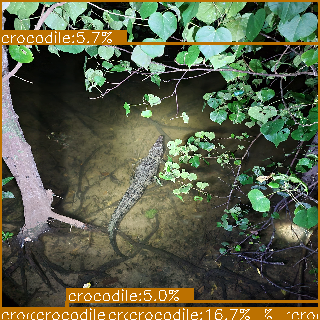

model size is  1.0x
init weights...
=> loading pretrained model https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth
Finish initialize NanoDet Head.
forward time: 0.045s | decode time: 0.012s | 

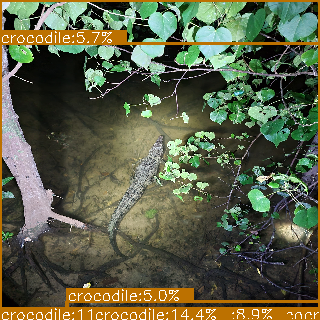

In [84]:
for epoch in [300, 500]:
    config_path = f'assets/nanodet-{epoch}/nanodet-{epoch}.pth_train_config.yml'
    model_path = f'assets/nanodet-{epoch}/nanodet-{epoch}.pth'
    image_path = 'dataset/night/20201201_000505.jpg'

    load_config(cfg, config_path)
    logger = Logger(-1, use_tensorboard=False)
    wrapper = WrapperModel(cfg, model_path, logger, device=device)

    res = wrapper.model.inference({"img": input_, 
                                   "warp_matrix": [ResizeM], 
                                   "img_info": {
                                       "id": [0],
                                       "height": [input_.shape[2]],
                                       "width": [input_.shape[3]],
                                   }})

    from nanodet.util import overlay_bbox_cv

    result = overlay_bbox_cv(numpy_img_warped, res[0], cfg.class_names, score_thresh=0)

    cv2_imshow(cv2.resize(result, None, fx=1.0, fy=1.0))

## Captum

In [6]:
from captum.attr import (Deconvolution, DeepLift, DeepLiftShap,
                         FeatureAblation, GradientShap, GuidedBackprop,
                         GuidedGradCam, InputXGradient, IntegratedGradients,
                         Occlusion, Saliency)

baseline = torch.zeros(input_.shape).to(device).type(torch.cuda.FloatTensor)

thres = 0.35
class_scores = wrapper(input_)
pred_class = 0

# ig = IntegratedGradients(wrapper)
# attributions, delta = ig.attribute(input_,
#                                     target=pred_class,
#                                     return_convergence_delta=True)
dl = DeepLift(wrapper)
attributions, delta = dl.attribute(input_, baseline, target=pred_class, return_convergence_delta=True)

/home/reedless/.venv/captum-vas/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/reedless/.venv/captum-vas/lib/python3.8/site-packages/torch/nn/functional.py:3499: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(
/home/reedless/.venv/captum-vas/lib/python3.8/site-packages/captum/_utils/gradient.py:56: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.

RuntimeError: A Module LeakyReLU(negative_slope=0.1, inplace=True) was detected that does not contain some of the input/output attributes that are required for DeepLift computations. This can occur, for example, if your module is being used more than once in the network.Please, ensure that module is being used only once in the network.

In [ ]:
attributions